In [3]:
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
import random
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.metrics import roc_curve, auc

def plot_variables(sig,bkg):
    X_sig = sig
    X_bkg = bkg
    for i in X_sig.columns.to_list():
        x = X_sig[i].to_numpy()
        y = X_bkg[i].to_numpy()
        bins = np.linspace(min([min(x),min(y)]),max([max(x),max(y)]), 100)
        print(i)
        plt.hist(x, bins, alpha=0.5, label='signal', density=True, color='blue')
        plt.hist(y, bins, alpha=0.5, label='W + Jets', density=True, color='red')
        #plt.hist(x, bins, alpha=0.5, label='signal', density=False)
        #plt.hist(y, bins, alpha=0.5, label='W + Jets', density=False)
        plt.legend(loc='upper right')
        plt.title("{}".format(i.split('[')[0]))
        plt.show()

def plot_variables_pairs(sig,bkg,sig_t,bkg_t):
    for i in sig.columns.to_list():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))
        fig.suptitle("{}".format(i.split('[')[0]))
        
        x = sig[i].to_numpy()
        y = bkg[i].to_numpy()
        bins = np.linspace(min([min(x),min(y)]),max([max(x),max(y)]), 100)
        print(i)
        ax1.hist(x, bins, alpha=0.5, label='signal', density=False, color='blue')
        ax1.hist(y, bins, alpha=0.5, label='W + Jets', density=False, color='red')
        #plt.hist(x, bins, alpha=0.5, label='signal', density=False)
        #plt.hist(y, bins, alpha=0.5, label='W + Jets', density=False)
        ax1.legend(loc='upper right')
        #ax1.title("train")
        
        x = sig_t[i].to_numpy()
        y = bkg_t[i].to_numpy()
        bins = np.linspace(min([min(x),min(y)]),max([max(x),max(y)]), 100)
        print(i)
        ax2.hist(x, bins, alpha=0.5, label='signal', density=False, color='blue')
        ax2.hist(y, bins, alpha=0.5, label='W + Jets', density=False, color='red')
        #plt.hist(x, bins, alpha=0.5, label='signal', density=False)
        #plt.hist(y, bins, alpha=0.5, label='W + Jets', density=False)
        ax2.legend(loc='upper right')
        #ax2.title("train")
        
        plt.show()
def plot_variables_pairs_same_binning(sig,bkg,sig_t,bkg_t):
    for i in sig.columns.to_list():
        
        fig = plt.figure()
        
        x_sig = sig[i].to_numpy()
        x_bkg = bkg[i].to_numpy()
        x_sig_t = sig_t[i].to_numpy()
        x_bkg_t = bkg_t[i].to_numpy()
        
        bins = np.linspace(min([min(x_sig),min(x_bkg),min(x_sig_t),min(x_bkg_t)]),max([max(x_sig),max(x_bkg),max(x_sig_t),max(x_bkg_t)]), 20)
        
        print(i)
        
        y,binEdges = np.histogram(x_sig,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.errorbar(bincenters, y,  color='b', yerr=menStd, label='signal (train)', fmt='o')
        
        y,binEdges = np.histogram(x_bkg,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.errorbar(bincenters, y,  color='r', yerr=menStd, label='background (train)', fmt='o')
        
        y,binEdges = np.histogram(x_sig_t,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.bar(bincenters, y, color='b', yerr=menStd, label='signal (test)', alpha=0.5)
        
        y,binEdges = np.histogram(x_bkg_t,bins=bins)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        menStd     = np.sqrt(y)
        plt.bar(bincenters, y, color='r', yerr=menStd, label='background (test)', alpha=0.5)
        
        plt.legend(loc='upper right')

        plt.show()

# Prepare dataset

In [4]:
sig = pd.read_csv('WpWpJJ_EWK_2017-pass_upToBVeto.gz.csv', compression = 'gzip')
bkg = pd.read_csv('Wjets_2017-pass_upToBVeto.gz.csv', compression = 'gzip')
#sig_ = pd.read_csv('WpWpJJ_EWK_2017.gz.csv', compression = 'gzip')
#bkg = pd.read_csv('Wjets_2017.gz.csv', compression = 'gzip')

In [5]:
print(sig.shape)
print(bkg.shape)
print()
sig=sig[sig['lepton_TightRegion[0]']==1]
bkg=bkg[bkg['lepton_TightRegion[0]']==1]
print(sig.shape)
print(bkg.shape)
print()
sig=sig[sig['tau_TightRegion[0]']==1]
bkg=bkg[bkg['tau_TightRegion[0]']==1]
print(sig.shape)
print(bkg.shape)
print()

to_drop = ['entry','w_nominal','lepSF[0]', 'lepUp[0]', 'lepDown[0]', 'puSF[0]', 'puUp[0]',
           'puDown[0]', 'PFSF[0]', 'PFUp[0]', 'PFDown[0]', 'q2Up[0]', 'q2Down[0]','w_PDF',
           'SF_Fake[0]','tau_isPrompt[0]','lepton_isPrompt[0]',
           'event_SFFake[0]','lepton_SFFake[0]', 'tau_SFFake[0]','tau_DeepTau_WP[0]',
           'tau_DeepTauVsJet_WP[0]', 'tau_DeepTauVsMu_WP[0]','tau_DeepTauVsEle_WP[0]', 'm_leptau[0]',
           'HLT_effLumi[0]', 'pass_lepton_selection[0]','pass_tau_selection[0]', 'pass_tau_vsJetWP[0]',
           'event_Zeppenfeld_over_deltaEta_jj[0]', 'pass_lepton_veto[0]', 'pass_charge_selection[0]', 'pass_b_veto[0]',
           'pass_jet_selection[0]', 'pass_upToBVeto[0]', 'nBJets[0]',
           'tau_Zeppenfeld_over_deltaEta_jj[0]', 'lepton_Zeppenfeld_over_deltaEta_jj[0]', 'lepton_LnTRegion[0]', 'tau_LnTRegion[0]', 'pass_lepton_iso[0]', 'tau_isolation[0]', 
           'lepton_TightRegion[0]','tau_TightRegion[0]' ]

sig = sig.drop(columns = to_drop)
bkg = bkg.drop(columns = to_drop)

new_columns = []
for i in sig.columns:
    new_columns.append(i.split('[')[0])
sig.columns = new_columns
bkg.columns = new_columns


(4156, 90)
(78100, 90)

(4108, 90)
(74961, 90)

(2479, 90)
(5588, 90)



<AxesSubplot:>

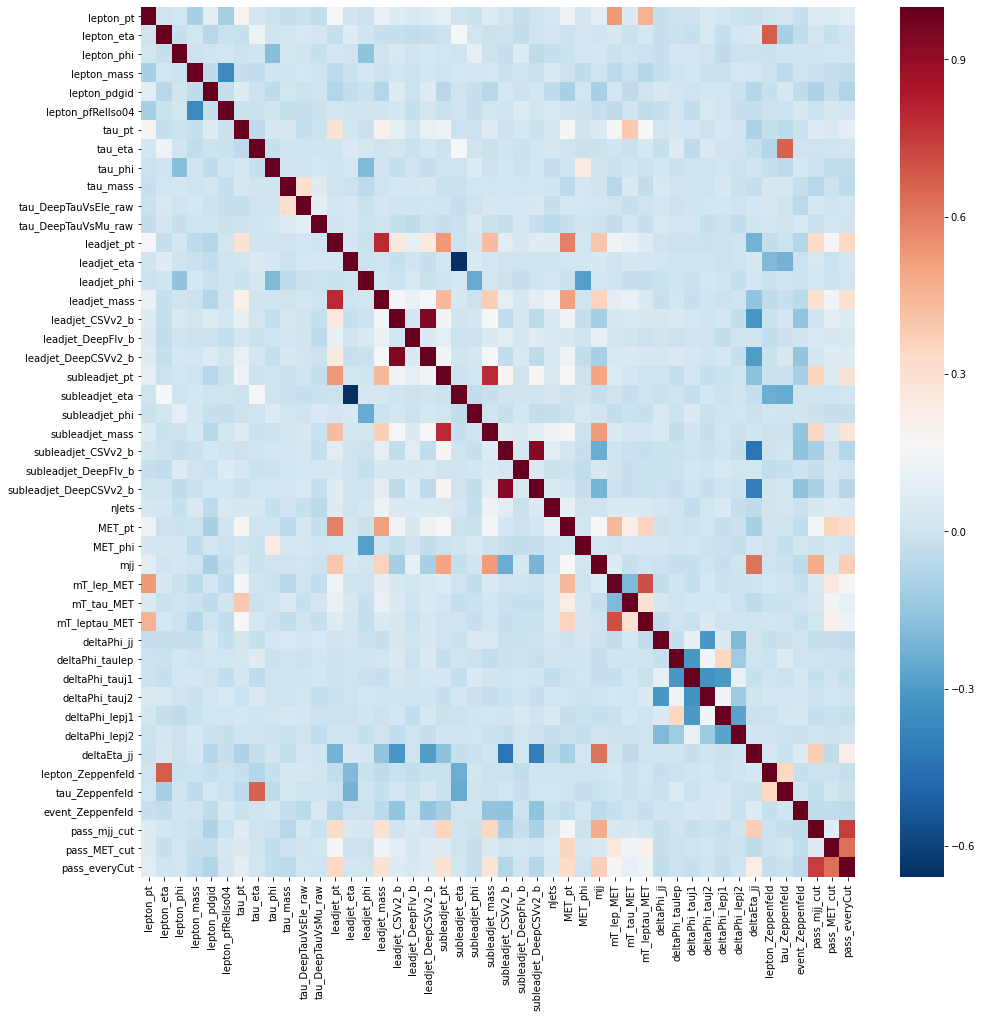

In [6]:
corr = sig.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(16,16))
sn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,  cmap = "RdBu_r")

<AxesSubplot:>

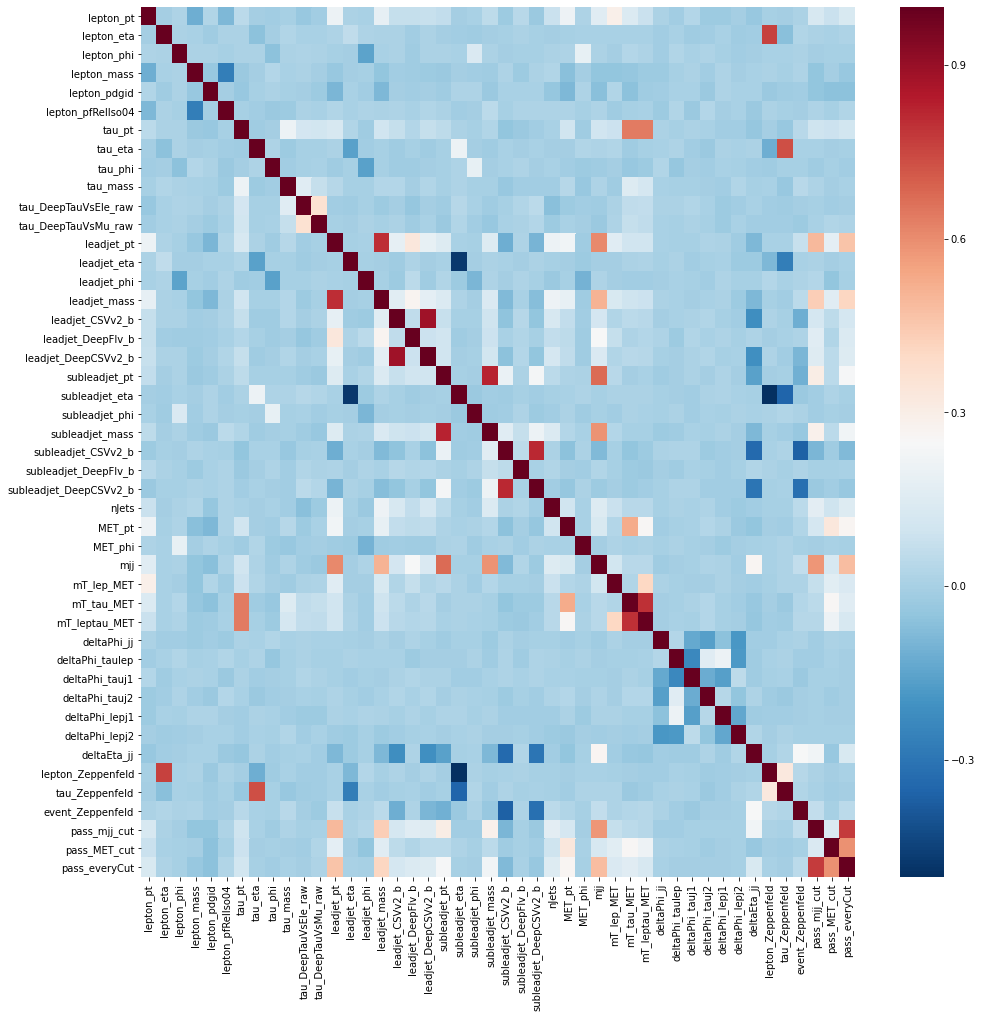

In [7]:
corr = bkg.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(16,16))
sn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,  cmap = "RdBu_r")

In [6]:
sig.columns

Index(['lepton_pt', 'lepton_eta', 'lepton_phi', 'lepton_mass', 'lepton_pdgid',
       'lepton_pfRelIso04', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_mass',
       'tau_DeepTauVsEle_raw', 'tau_DeepTauVsMu_raw', 'leadjet_pt',
       'leadjet_eta', 'leadjet_phi', 'leadjet_mass', 'leadjet_CSVv2_b',
       'leadjet_DeepFlv_b', 'leadjet_DeepCSVv2_b', 'subleadjet_pt',
       'subleadjet_eta', 'subleadjet_phi', 'subleadjet_mass',
       'subleadjet_CSVv2_b', 'subleadjet_DeepFlv_b', 'subleadjet_DeepCSVv2_b',
       'nJets', 'MET_pt', 'MET_phi', 'mjj', 'mT_lep_MET', 'mT_tau_MET',
       'mT_leptau_MET', 'deltaPhi_jj', 'deltaPhi_taulep', 'deltaPhi_tauj1',
       'deltaPhi_tauj2', 'deltaPhi_lepj1', 'deltaPhi_lepj2', 'deltaEta_jj',
       'lepton_Zeppenfeld', 'tau_Zeppenfeld', 'event_Zeppenfeld',
       'pass_mjj_cut', 'pass_MET_cut', 'pass_everyCut'],
      dtype='object')

In [7]:
sig_balanced = sig
bkg_balanced = bkg.sample(n=sig_balanced.shape[0])

X_sig = sig_balanced.to_numpy()
X_bkg = bkg_balanced.to_numpy()
y_sig = np.ones(X_sig.shape[0])
y_bkg = - np.ones(X_bkg.shape[0])
X = np.concatenate([X_sig,X_bkg])
y = np.concatenate([y_sig,y_bkg])
X_shuffled, y_shuffled = shuffle(X, y)
#split_value = 940
#split_value = int(X.shape[0]*5./6.)
split_value = int(X.shape[0]*1./2.)
X_train, X_test = X_shuffled[:split_value], X_shuffled[split_value:]
y_train, y_test = y_shuffled[:split_value], y_shuffled[split_value:]

print(X_train.shape[0])
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print(X_test.shape[0])
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

2479
{-1.0: 1218, 1.0: 1261}
2479
{-1.0: 1261, 1.0: 1218}


# Train classifier

scikit learn score:  0.8257361839451391
[-0.05231991  0.08930623  0.00118959 ... -0.24899428 -0.29793982
  0.06743431]
user score:  0.8257361839451391
[-0.05231991  0.08930623  0.00118959 ... -0.24899428 -0.29793982
  0.06743431]
user score:  0.491327148043566


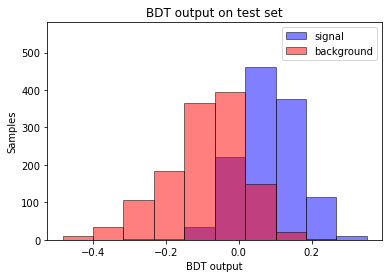

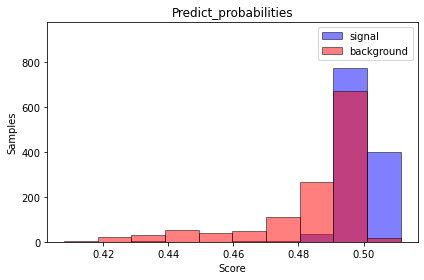

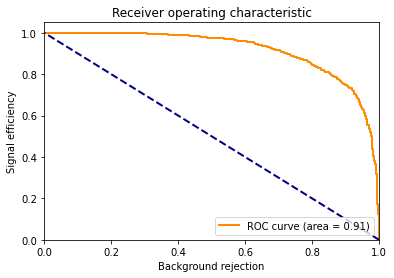

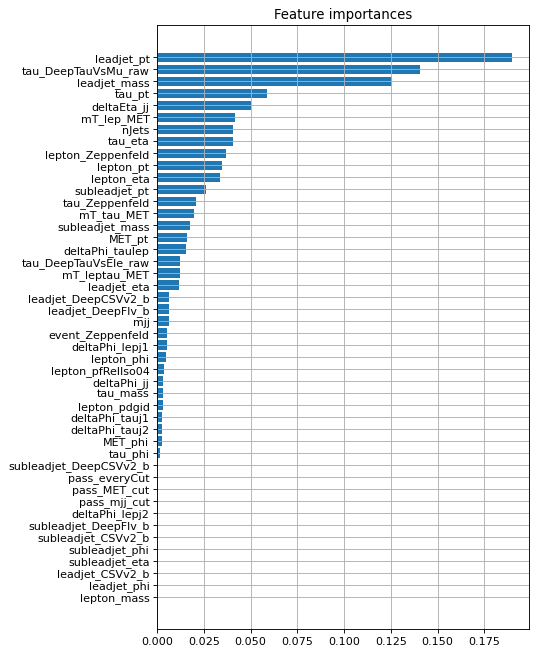

5000


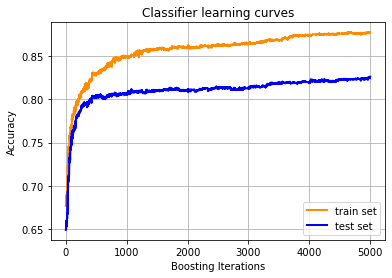

In [9]:
df_ada = pd.DataFrame(columns=['time', 'score', 'ROC auc'])

y_train_ada = np.copy(y_train)
y_train_ada[y_train_ada==-1.]=0
y_train_ada[y_train_ada==1.]=1
y_test_ada = np.copy(y_test)
y_test_ada[y_test_ada==-1.]=0
y_test_ada[y_test_ada==1.]=1


for n_trees in [5000]:
    start = time.time()
    adabdt = AdaBoostClassifier(n_estimators=n_trees, random_state=0, learning_rate=0.1,  algorithm='SAMME').fit(X_train, y_train_ada)
    end = time.time()
    delta_t = end - start
    print('scikit learn score: ',adabdt.score(X_test, y_test_ada))
    score = adabdt.score(X_test, y_test_ada)

    #twoclass_output = bdt
    print(adabdt.decision_function(X_test))
    twoclass_output = adabdt.decision_function(X_test)
    #twoclass_output = adabdt.predict_proba(X_test)[:,1]
    predictions = [1. if x >= 0. else 0. for x in twoclass_output]
    print('user score: ',sum(1 for x,y in zip(predictions,y_test_ada) if x == y) / len(y_test_ada))
    #print(twoclass_output)
    plot_range = (twoclass_output.min(), twoclass_output.max())
    for i, n, c in zip([1.,0.], ['signal','background'], ['blue', 'red']):
        plt.hist(twoclass_output[y_test_ada == i],
                 bins=10,
                 range=plot_range,
                 facecolor=c,
                 label= n,
                 alpha=.5,
                 edgecolor='k')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, y1, y2 * 1.2))
    plt.legend(loc='upper right')
    plt.ylabel('Samples')
    plt.xlabel('BDT output')
    plt.title('BDT output on test set')
    
    #twoclass_output = bdt
    
    plt.figure()
    print(adabdt.decision_function(X_test))
    #twoclass_output = adabdt.decision_function(X_test)
    twoclass_output = adabdt.predict_proba(X_test)[:,1]
    predictions = [1. if x >= 0. else 0. for x in twoclass_output]
    print('user score: ',sum(1 for x,y in zip(predictions,y_test_ada) if x == y) / len(y_test_ada))
    #print(twoclass_output)
    plot_range = (twoclass_output.min(), twoclass_output.max())
    for i, n, c in zip([1.,0.], ['signal','background'], ['blue', 'red']):
        plt.hist(twoclass_output[y_test_ada == i],
                 bins=10,
                 range=plot_range,
                 facecolor=c,
                 label= n,
                 alpha=.5,
                 edgecolor='k')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, y1, y2 * 1.2))
    plt.legend(loc='upper right')
    plt.ylabel('Samples')
    plt.xlabel('Score')
    plt.title('Predict_probabilities')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35)
    plt.show()

    #for i in range(0,len(columns)):
    #    print(columns[i]," ---------> ", importance[i])

    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_test_ada, adabdt.decision_function(X_test))
    #fpr, tpr, _ = roc_curve(y_test_ada, adabdt.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(1. - fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([1, 0], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Background rejection')
    plt.ylabel('Signal efficiency')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    importance = adabdt.feature_importances_
    columns = sig.columns
    zipped = zip (columns, importance)
    z = list(sorted(zipped, key = lambda t: t[1],reverse=False))
    #x = [z_[0].split('[')[0] for z_ in z if z_[1]>0.0]
    #y = [z_[1] for z_ in z if z_[1]>0.0]
    x = [z_[0].split('[')[0] for z_ in z]
    y = [z_[1] for z_ in z ]
    plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.barh(x, y)
    plt.grid()
    plt.title("Feature importances")
    plt.show()
    df_ada.loc[n_trees]=[delta_t,score,roc_auc] 
    
    train_accuracy = np.zeros((n_trees,), dtype=np.float64)
    test_accuracy = np.zeros((n_trees,), dtype=np.float64)
    for i, y_pred in enumerate(adabdt.staged_predict(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_accuracy[i] = accuracy_score(y_test_ada,y_pred)
        #test_deviance[i] = adabdt.loss_(y_test_ada, y_pred)
    for i, y_pred in enumerate(adabdt.staged_predict(X_train)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        train_accuracy[i] = accuracy_score(y_train_ada,y_pred)
        #test_deviance[i] = adabdt.loss_(y_test_ada, y_pred)
    print(len(test_accuracy))
    plt.plot(range(0,len(train_accuracy)),train_accuracy, color='darkorange',lw=lw, label='train set')
    plt.plot(range(0,len(test_accuracy)),test_accuracy, color='blue',lw=lw, label='test set')
    #plt.plot(range(0,len(test_accuracy)),max(test_accuracy)*np.ones(len(test_accuracy)), color='black',lw=lw, label='test set')
    plt.title('Classifier learning curves')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

# Analyze classifier

[-0.05231991  0.08930623  0.00118959 ... -0.24899428 -0.29793982
  0.06743431]
user score:  0.8257361839451391


Text(0.5, 1.0, 'BDT output on test set')

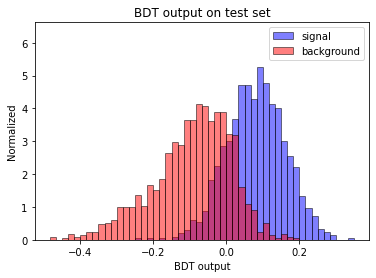

In [18]:
print(adabdt.decision_function(X_test))
twoclass_output = adabdt.decision_function(X_test)
#twoclass_output = adabdt.predict_proba(X_test)[:,1]
predictions = [1. if x >= 0. else 0. for x in twoclass_output]
print('user score: ',sum(1 for x,y in zip(predictions,y_test_ada) if x == y) / len(y_test_ada))
#print(twoclass_output)
plot_range = (twoclass_output.min(), twoclass_output.max())
for i, n, c in zip([1.,0.], ['signal','background'], ['blue', 'red']):
    plt.hist(twoclass_output[y_test_ada == i],
             bins=50,
             range=plot_range,
             facecolor=c,
             label= n,
             alpha=.5,
             edgecolor='k', density = True)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Normalized')
plt.xlabel('BDT output')
plt.title('BDT output on test set')

In [11]:
for i in range(len(fpr)):
    print(fpr[i], tpr[i], _[i])
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_ada, adabdt.decision_function(X_test))

0.0 0.0 1.3516960734592431
0.0 0.0008210180623973727 0.3516960734592432
0.0 0.07717569786535304 0.19526619745314966
0.0007930214115781126 0.07717569786535304 0.19471841429263526
0.0007930214115781126 0.12233169129720854 0.1756626839802271
0.0015860428231562252 0.12233169129720854 0.17532859903648607
0.0015860428231562252 0.1297208538587849 0.17238196509999143
0.0023790642347343376 0.1297208538587849 0.17213949167317472
0.0023790642347343376 0.1469622331691297 0.1658579339869165
0.0031720856463124504 0.1469622331691297 0.16543279558769308
0.0031720856463124504 0.16091954022988506 0.16223550871553283
0.003965107057890563 0.16091954022988506 0.161530245909074
0.003965107057890563 0.17159277504105092 0.1574743399783955
0.004758128469468675 0.17159277504105092 0.15712793447873274
0.004758128469468675 0.19376026272577998 0.15145022214952247
0.0055511498810467885 0.19376026272577998 0.1511397736674806
0.0055511498810467885 0.2471264367816092 0.13816925194276797
0.006344171292624901 0.24712643

0.9149572432544348

In [12]:
predictions = [1. if x >= -0.057242754114334826 else 0. for x in twoclass_output]
num=0
den=0
for x,y in zip(predictions,y_test_ada):
    if y==1:
        den +=1
        if x == y:
            num +=1
print("true positive rate ", num/den)


predictions = [1. if x >= -0.057242754114334826 else 0. for x in twoclass_output]
num=0
den=0
for x,y in zip(predictions,y_test_ada):
    if y==0.:
        den +=1
        if x != y:
            num +=1
print("false negative rate ", num/den)

true positive rate  0.9589490968801314
false negative rate  0.41712926249008725


lepton_pt


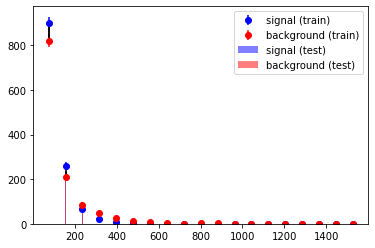

lepton_eta


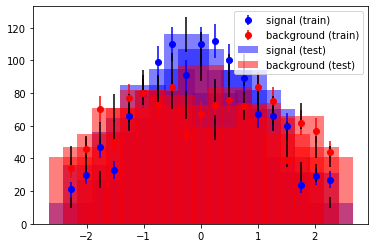

lepton_phi


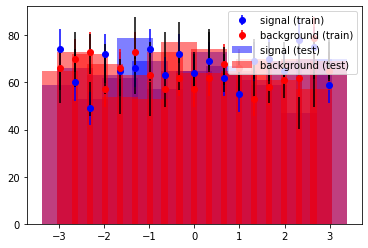

lepton_mass


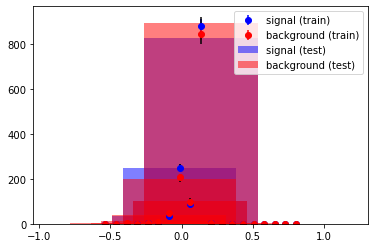

lepton_pdgid


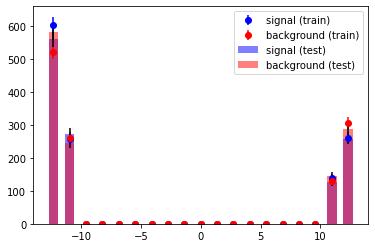

lepton_pfRelIso04


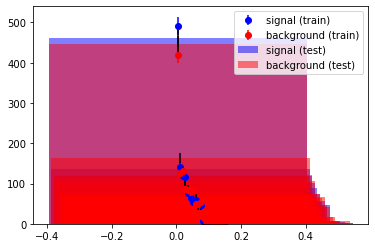

tau_pt


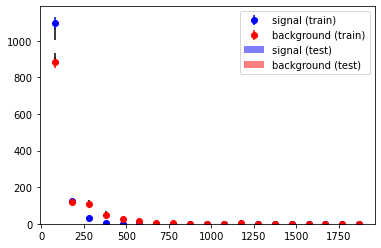

tau_eta


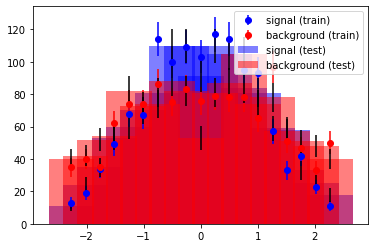

tau_phi


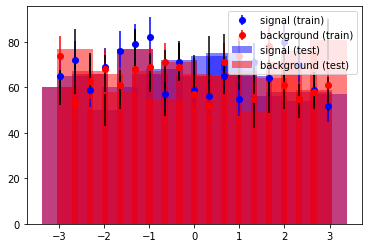

tau_mass


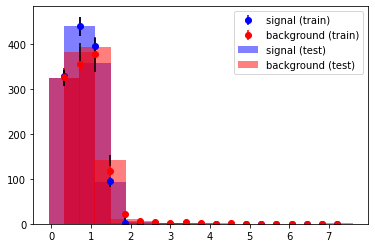

tau_DeepTauVsEle_raw


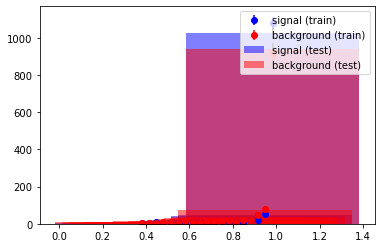

tau_DeepTauVsMu_raw


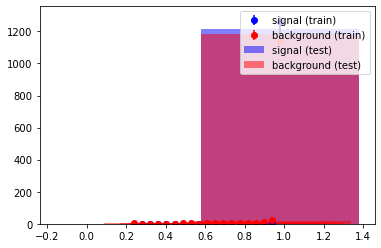

leadjet_pt


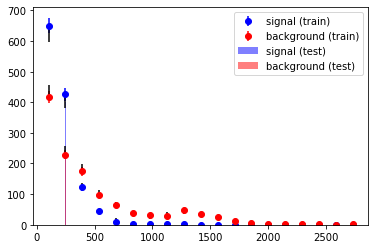

leadjet_eta


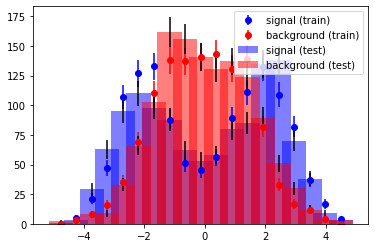

leadjet_phi


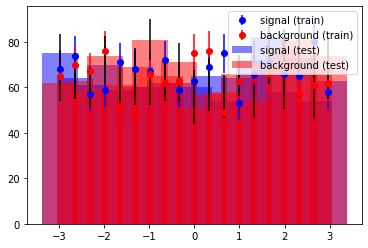

leadjet_mass


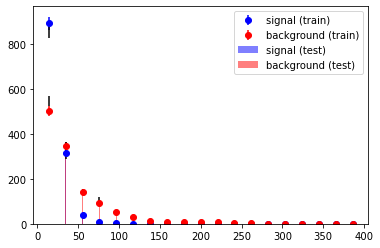

leadjet_CSVv2_b


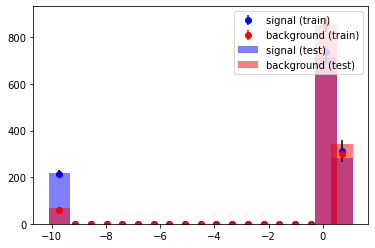

leadjet_DeepFlv_b


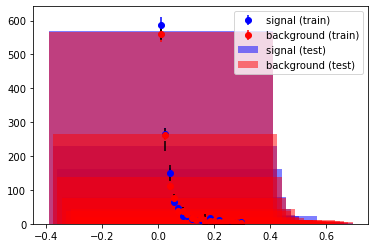

leadjet_DeepCSVv2_b


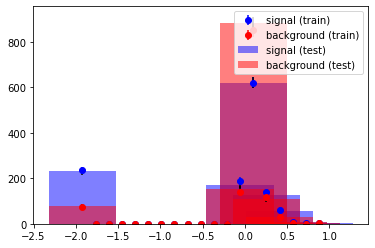

subleadjet_pt


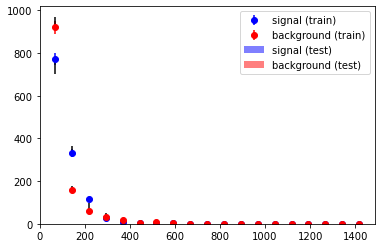

subleadjet_eta


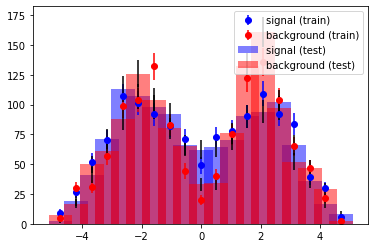

subleadjet_phi


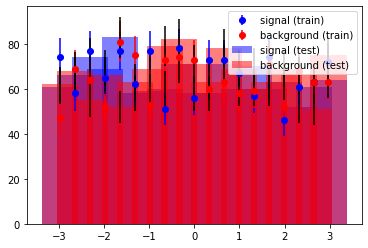

subleadjet_mass


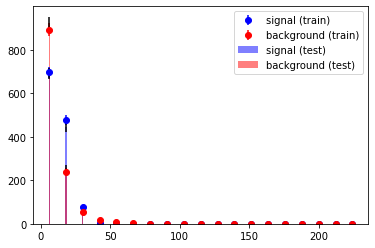

subleadjet_CSVv2_b


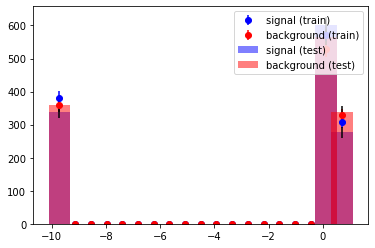

subleadjet_DeepFlv_b


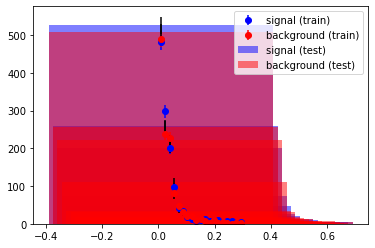

subleadjet_DeepCSVv2_b


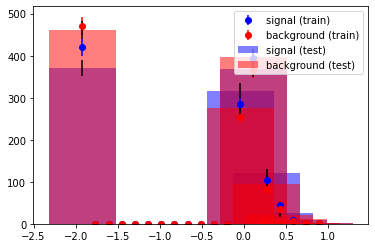

nJets


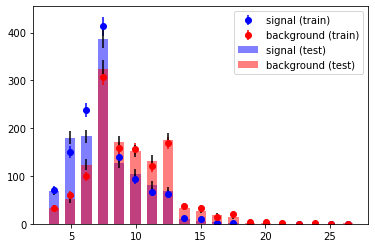

MET_pt


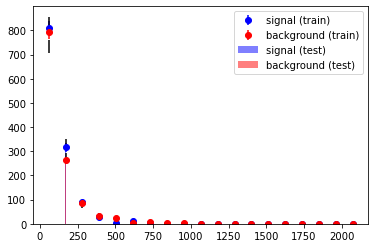

MET_phi


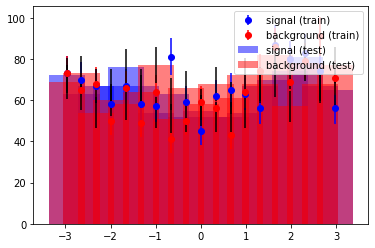

mjj


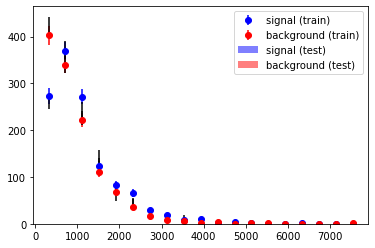

mT_lep_MET


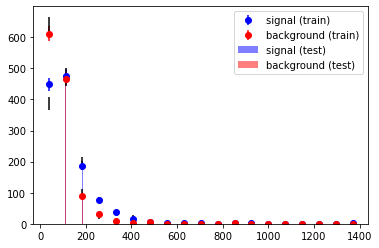

mT_tau_MET


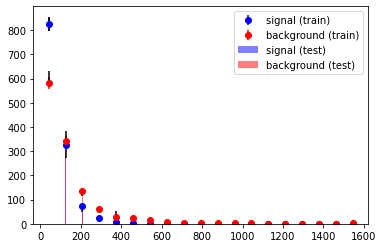

mT_leptau_MET


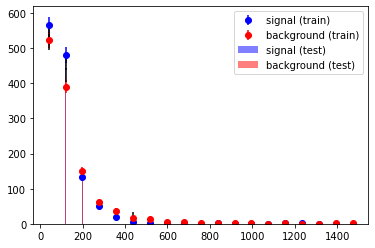

deltaPhi_jj


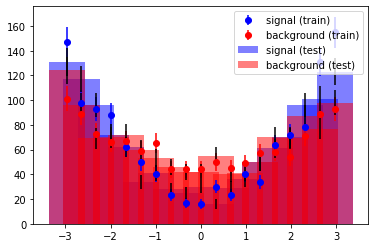

deltaPhi_taulep


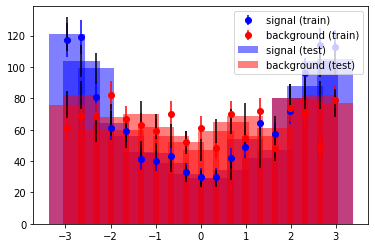

deltaPhi_tauj1


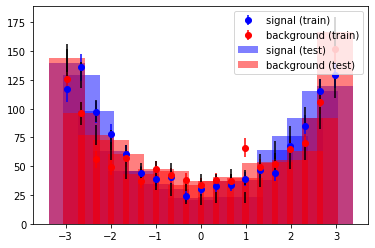

deltaPhi_tauj2


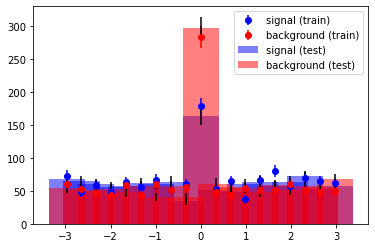

deltaPhi_lepj1


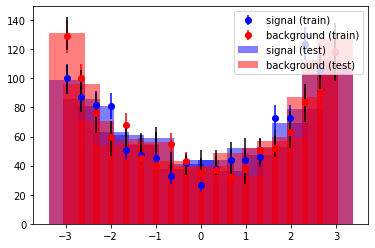

deltaPhi_lepj2


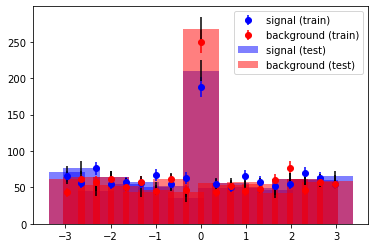

deltaEta_jj


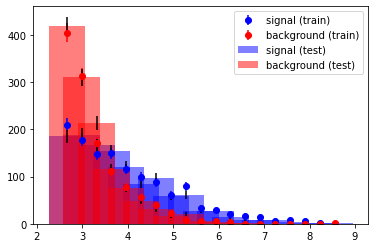

lepton_Zeppenfeld


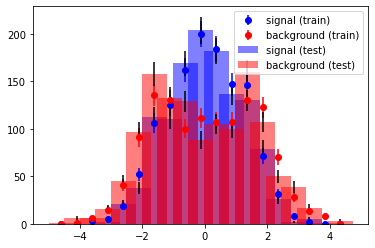

tau_Zeppenfeld


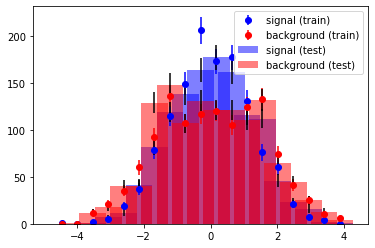

event_Zeppenfeld


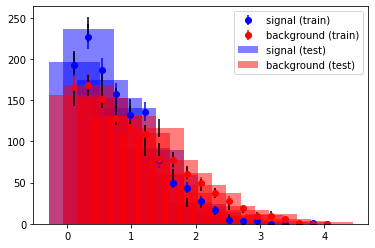

pass_mjj_cut


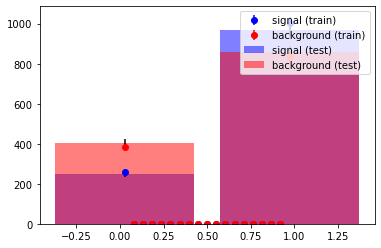

pass_MET_cut


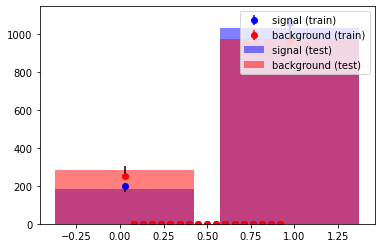

pass_everyCut


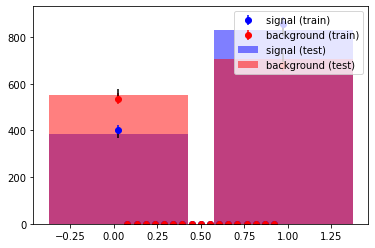

label


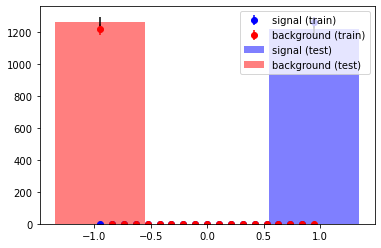

adabdt output


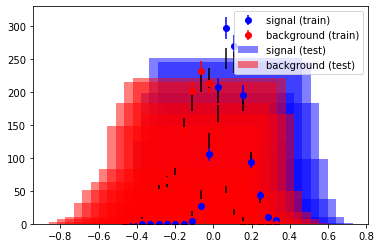

In [13]:
df_train = pd.DataFrame(X_train, columns=sig.columns)
df_train['label'] = y_train
df_train['adabdt output'] = adabdt.decision_function(X_train)
#df['gradbdt output'] = gradbdt.decision_function(X_test)
#df_train['adabdt output'] = adabdt.predict_proba(X_train)[:,1]
df_sig_train = df_train[df_train['label']==1.0]
df_bkg_train = df_train[df_train['label']==-1.0]

df_test = pd.DataFrame(X_test, columns=sig.columns)
df_test['label'] = y_test
df_test['adabdt output'] = adabdt.decision_function(X_test)
#df['adabdt output'] = adabdt.decision_function(X_test)
#df['gradbdt output'] = gradbdt.decision_function(X_test)
#df_test['adabdt output'] = adabdt.predict_proba(X_test)[:,1]
df_sig_test = df_test[df_test['label']==1.0]
df_bkg_test = df_test[df_test['label']==-1.0]

#plot_variables_pairs(df_sig_train,df_bkg_train,df_sig_test,df_bkg_test)
plot_variables_pairs_same_binning(df_sig_train,df_bkg_train,df_sig_test,df_bkg_test)

In [14]:

#df_train = pd.DataFrame(X_train, columns=sig.columns)
#df_train['label'] = y_train
#df_train.to_csv('df_train_new.csv')
#df_test = pd.DataFrame(X_test, columns=sig.columns)
#df_test['label'] = y_test
#df_test.to_csv('df_test_new.csv')

In [15]:
#df_1 = pd.read_csv('df_train.csv')
#df_1
#df_2 = pd.read_csv('df_test.csv')
#df_2

lepton_pt
lepton_pt


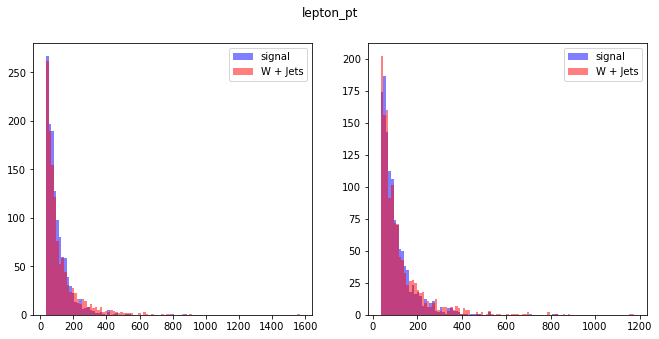

lepton_eta
lepton_eta


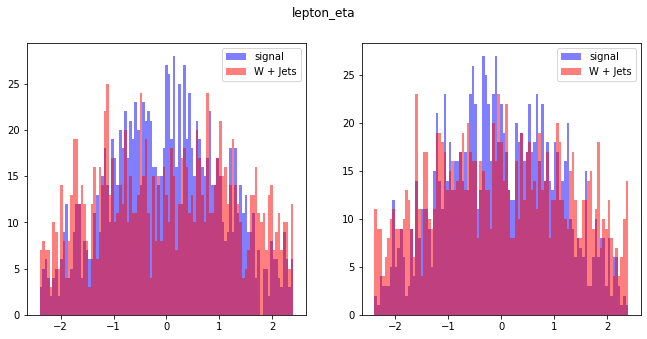

lepton_phi
lepton_phi


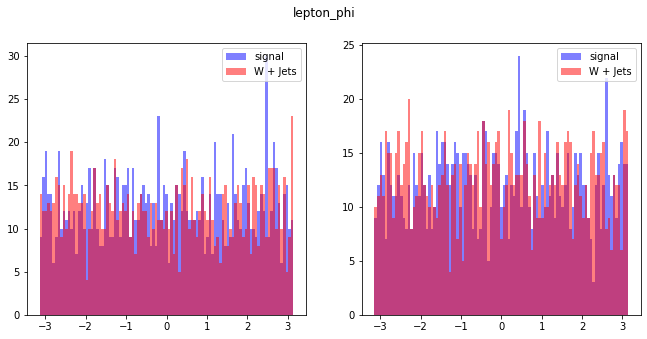

lepton_mass
lepton_mass


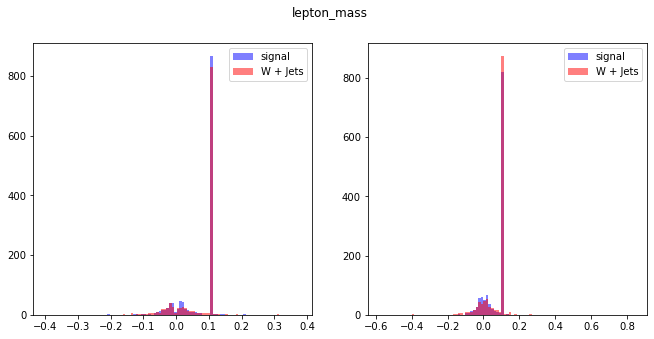

lepton_pdgid
lepton_pdgid


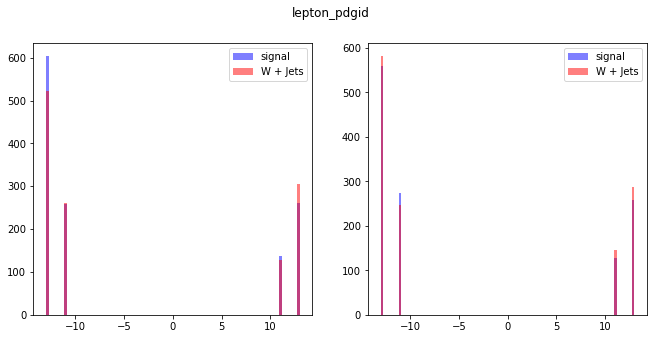

lepton_pfRelIso04
lepton_pfRelIso04


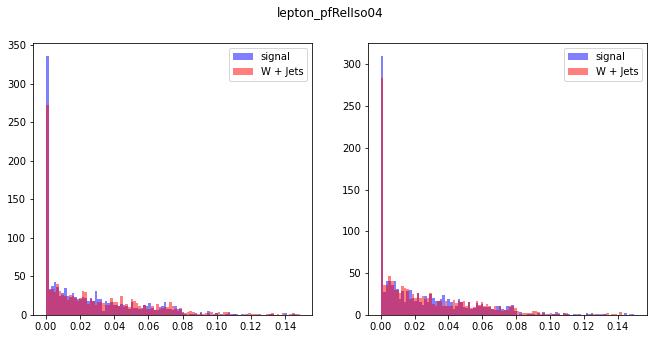

tau_pt
tau_pt


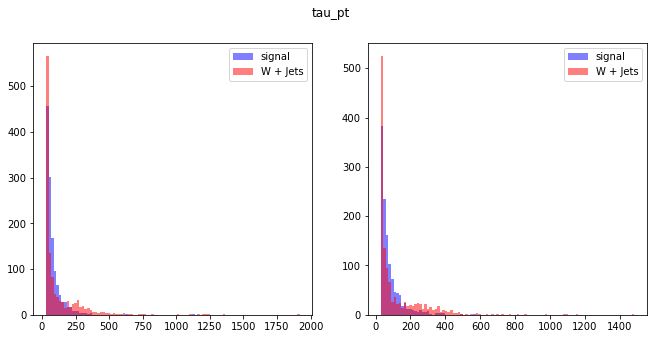

tau_eta
tau_eta


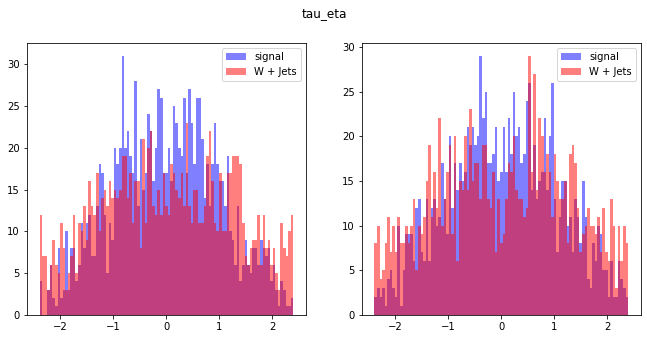

tau_phi
tau_phi


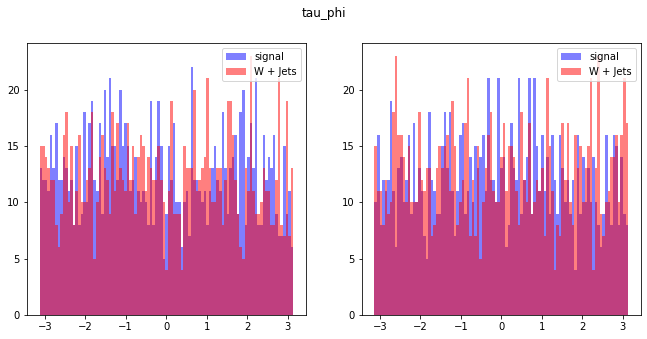

tau_mass
tau_mass


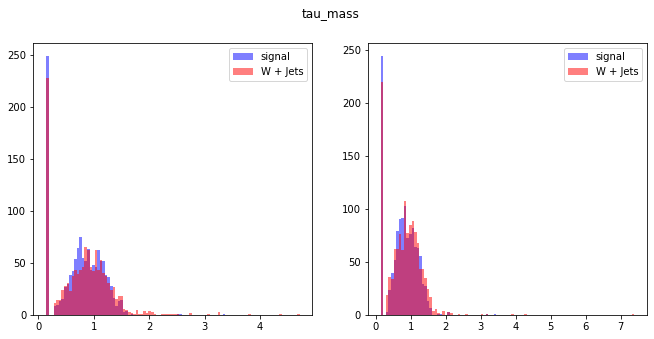

tau_DeepTauVsEle_raw
tau_DeepTauVsEle_raw


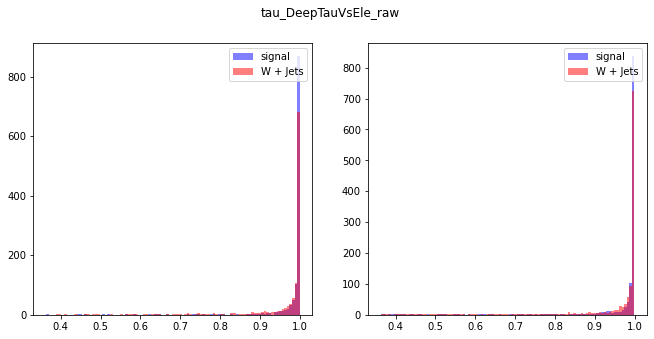

tau_DeepTauVsMu_raw
tau_DeepTauVsMu_raw


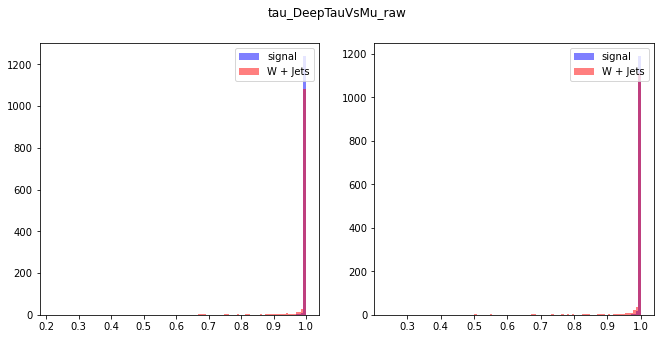

leadjet_pt
leadjet_pt


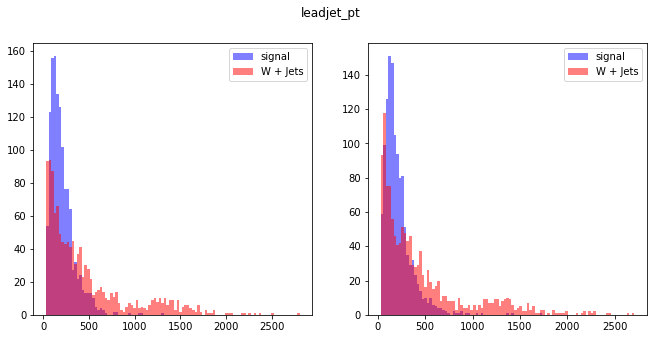

leadjet_eta
leadjet_eta


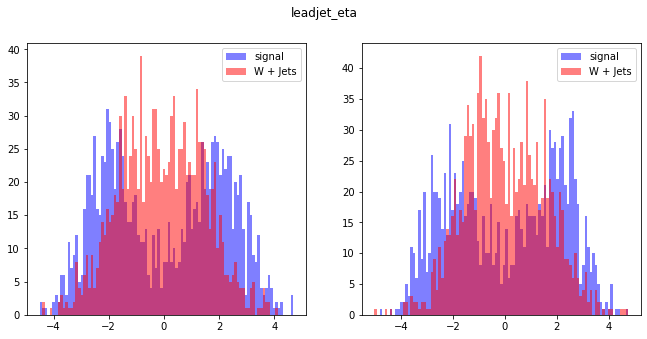

leadjet_phi
leadjet_phi


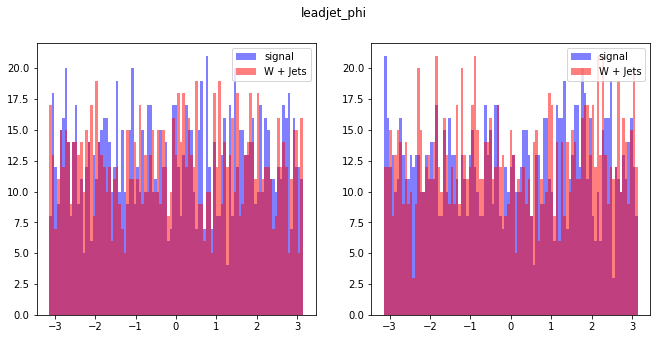

leadjet_mass
leadjet_mass


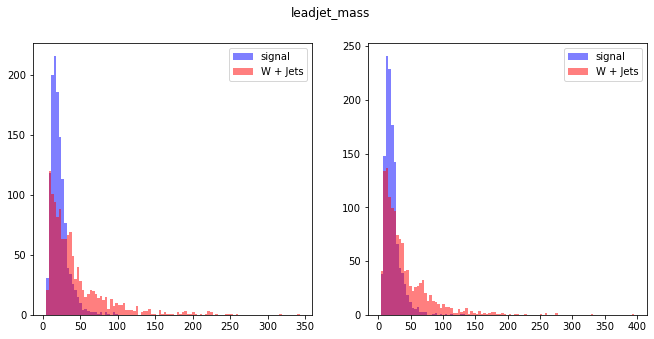

leadjet_CSVv2_b
leadjet_CSVv2_b


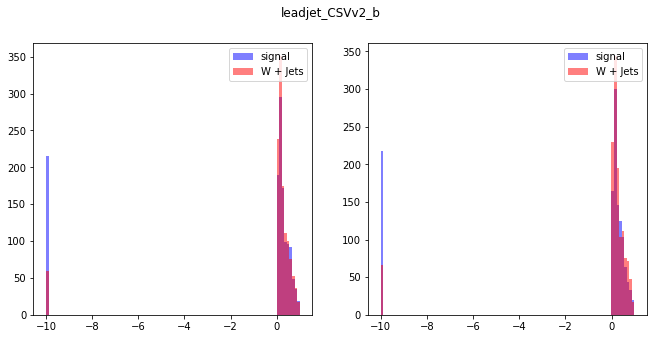

leadjet_DeepFlv_b
leadjet_DeepFlv_b


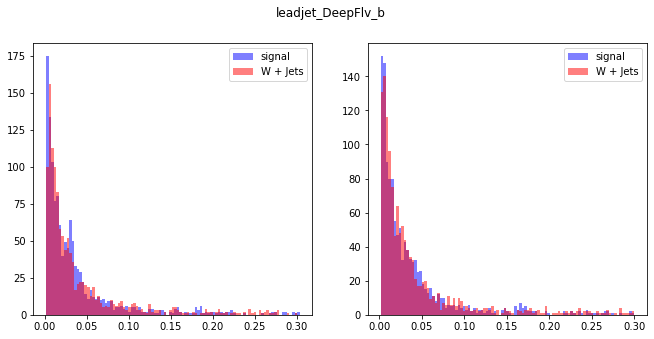

leadjet_DeepCSVv2_b
leadjet_DeepCSVv2_b


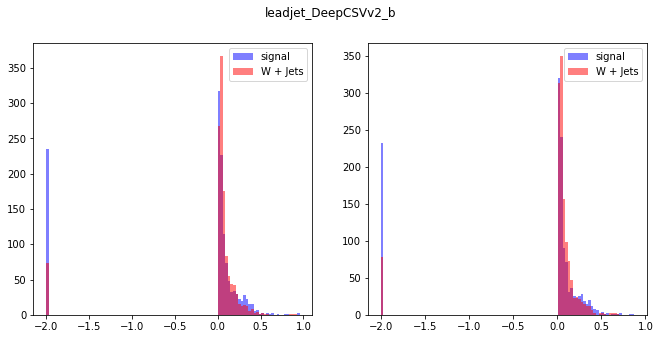

subleadjet_pt
subleadjet_pt


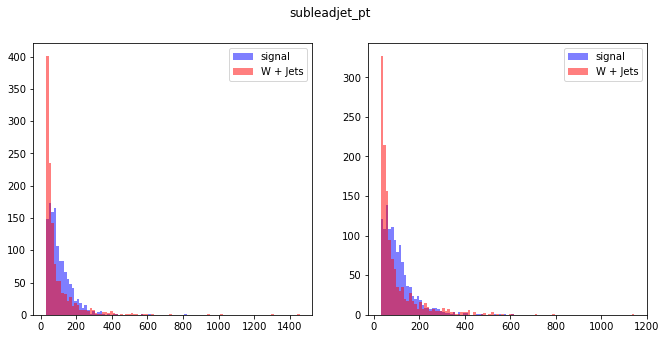

subleadjet_eta
subleadjet_eta


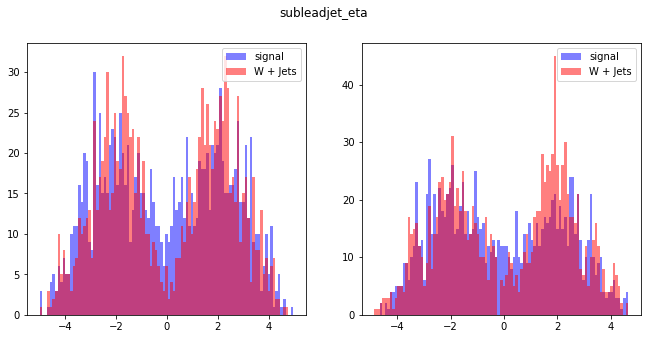

subleadjet_phi
subleadjet_phi


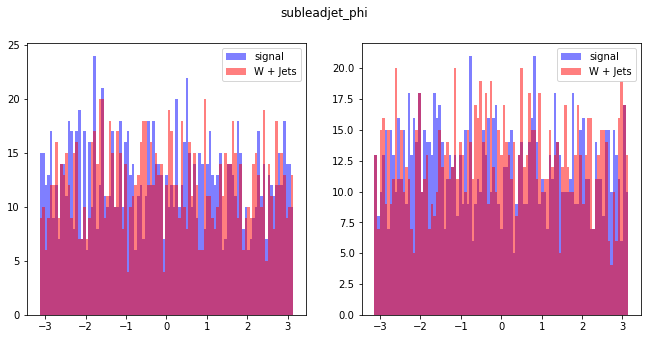

subleadjet_mass
subleadjet_mass


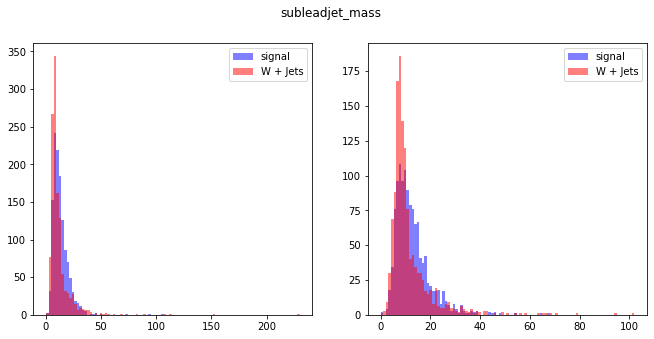

subleadjet_CSVv2_b
subleadjet_CSVv2_b


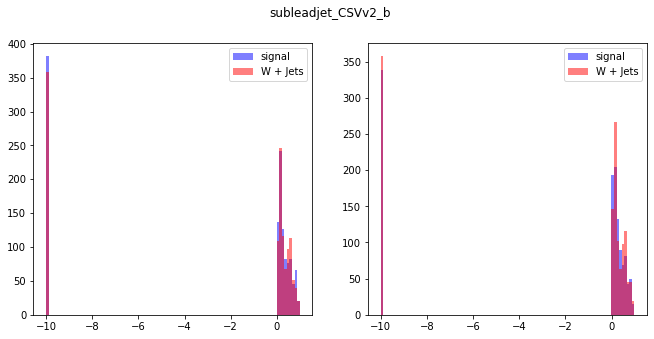

subleadjet_DeepFlv_b
subleadjet_DeepFlv_b


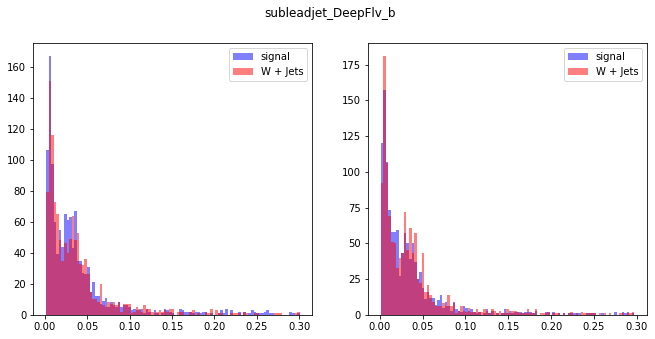

subleadjet_DeepCSVv2_b
subleadjet_DeepCSVv2_b


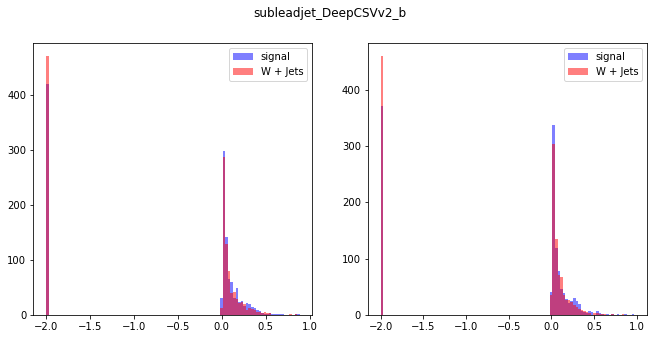

nJets
nJets


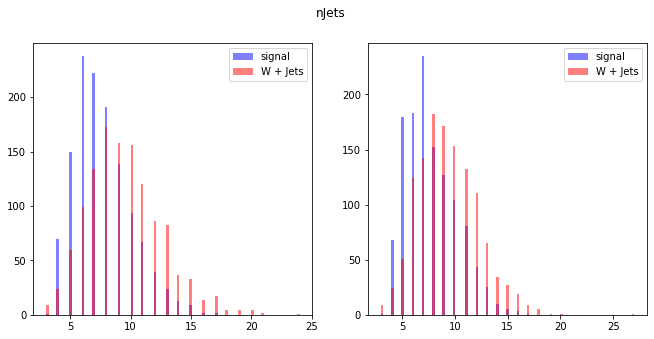

MET_pt
MET_pt


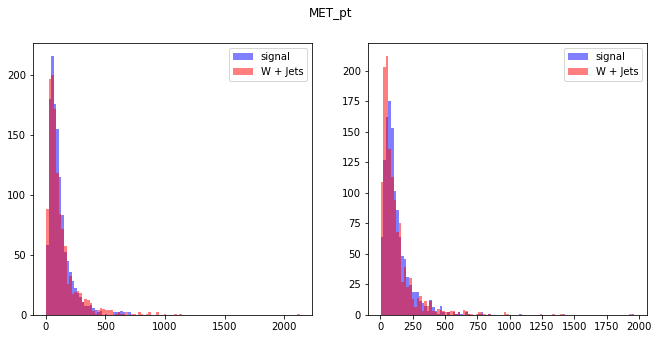

MET_phi
MET_phi


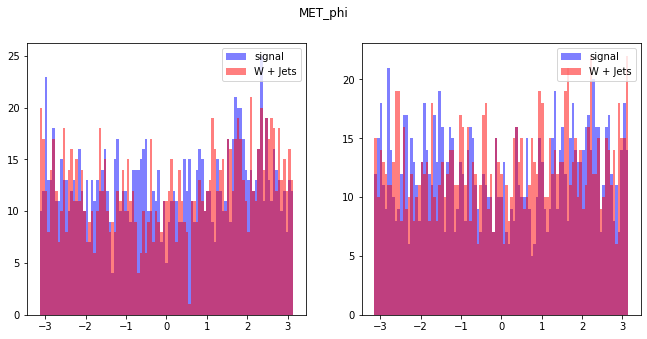

mjj
mjj


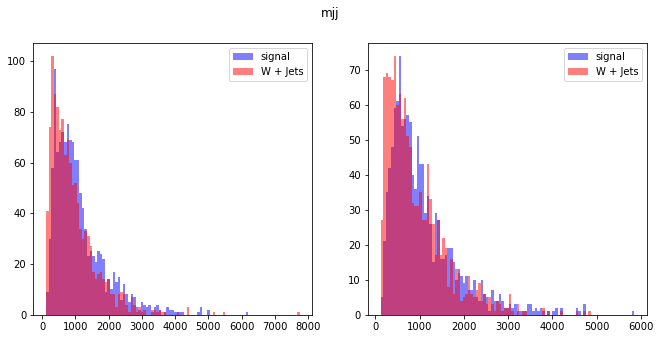

mT_lep_MET
mT_lep_MET


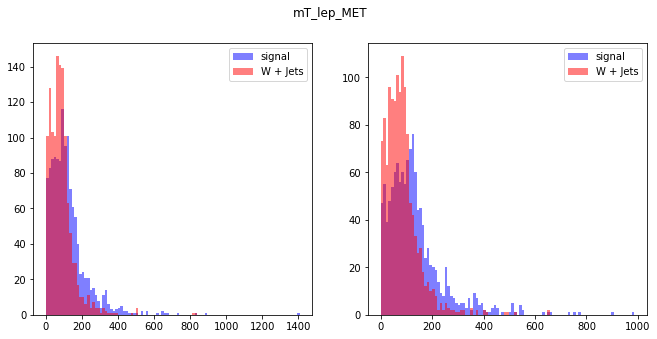

mT_tau_MET
mT_tau_MET


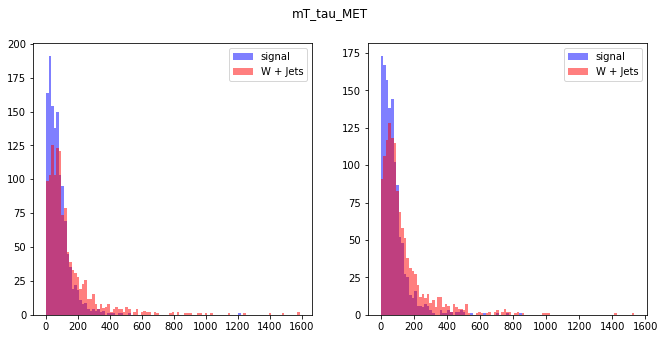

mT_leptau_MET
mT_leptau_MET


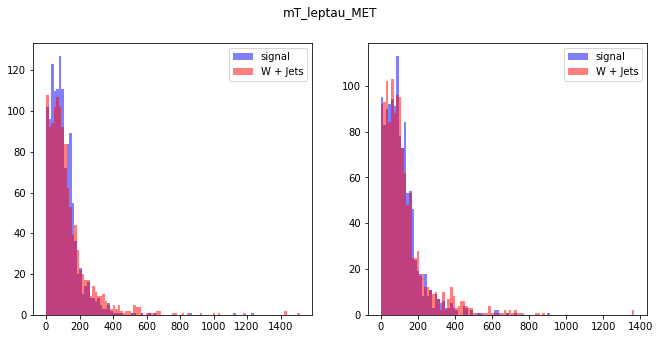

deltaPhi_jj
deltaPhi_jj


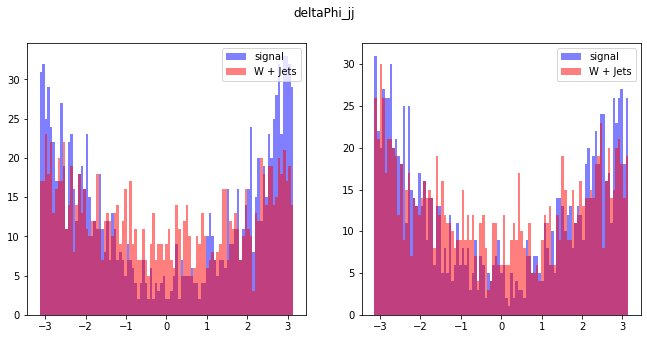

deltaPhi_taulep
deltaPhi_taulep


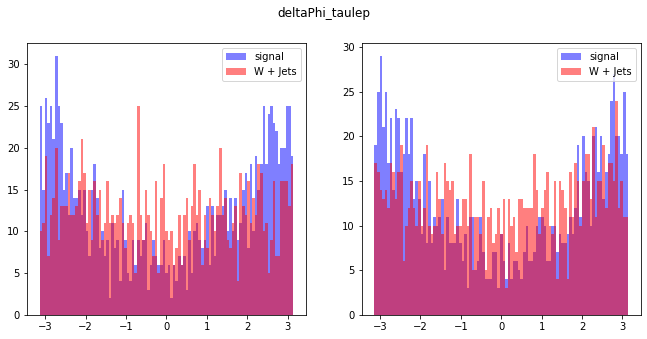

deltaPhi_tauj1
deltaPhi_tauj1


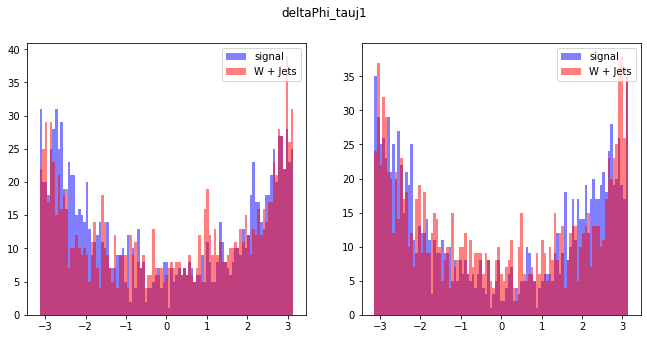

deltaPhi_tauj2
deltaPhi_tauj2


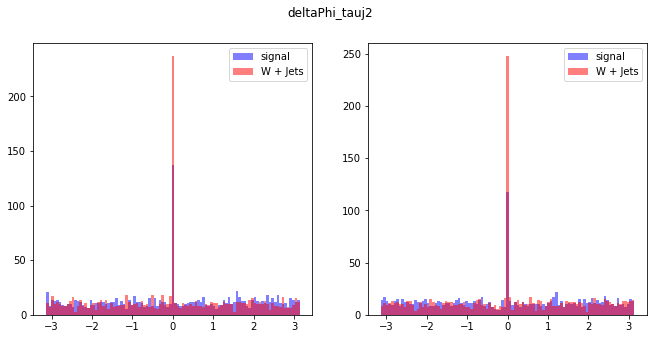

deltaPhi_lepj1
deltaPhi_lepj1


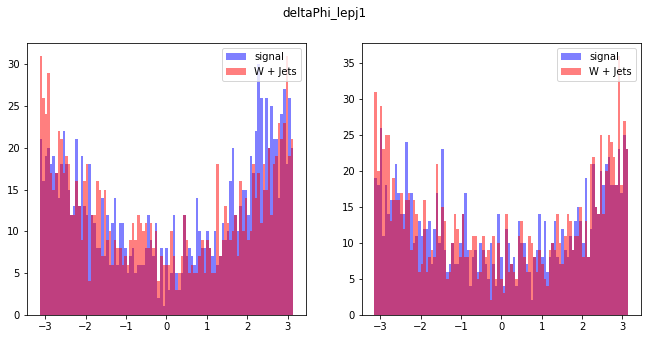

deltaPhi_lepj2
deltaPhi_lepj2


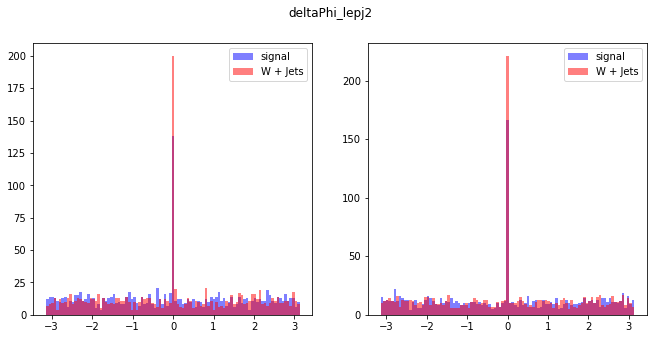

deltaEta_jj
deltaEta_jj


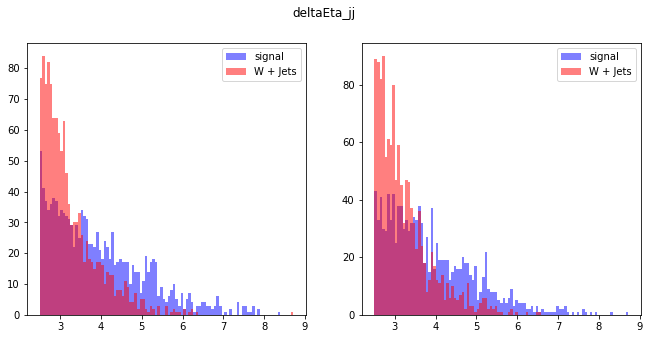

lepton_Zeppenfeld
lepton_Zeppenfeld


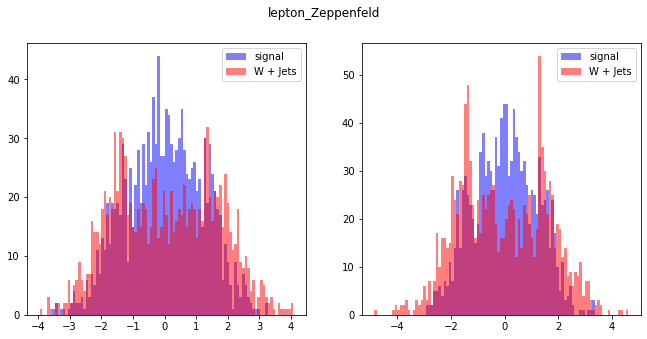

tau_Zeppenfeld
tau_Zeppenfeld


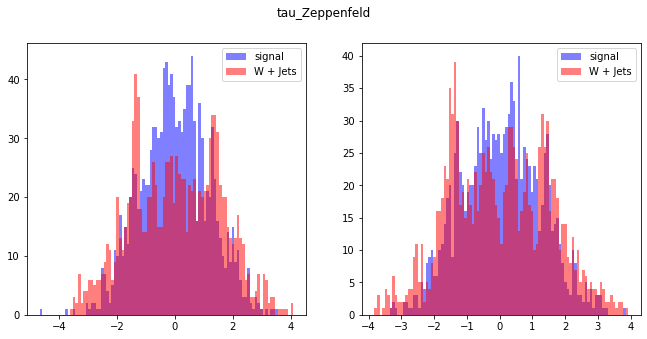

event_Zeppenfeld
event_Zeppenfeld


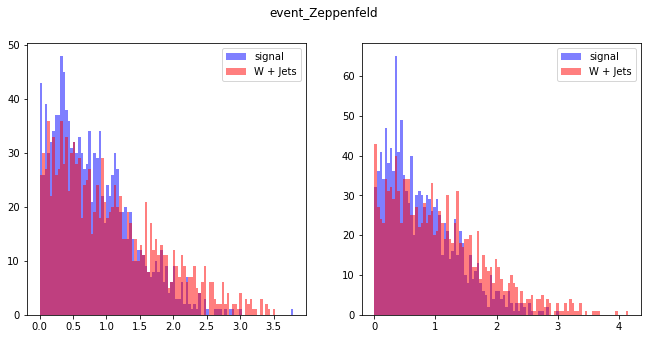

pass_mjj_cut
pass_mjj_cut


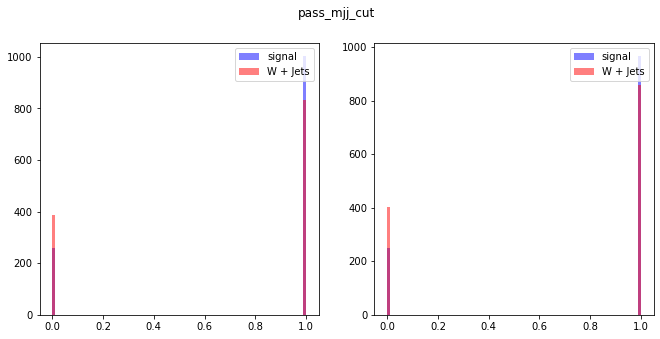

pass_MET_cut
pass_MET_cut


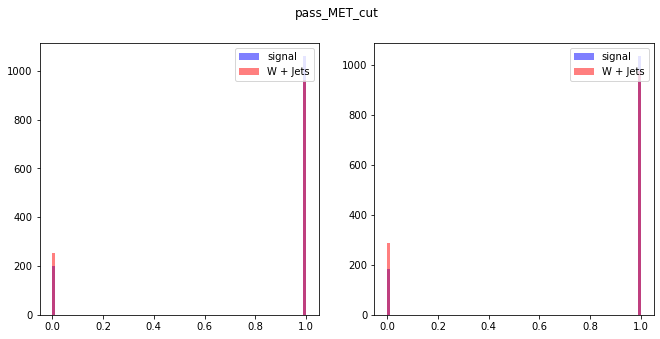

pass_everyCut
pass_everyCut


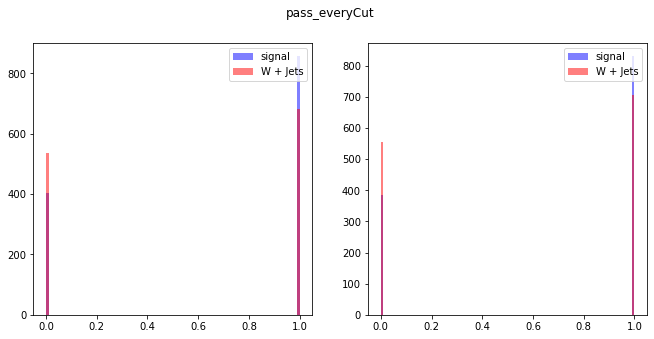

label
label


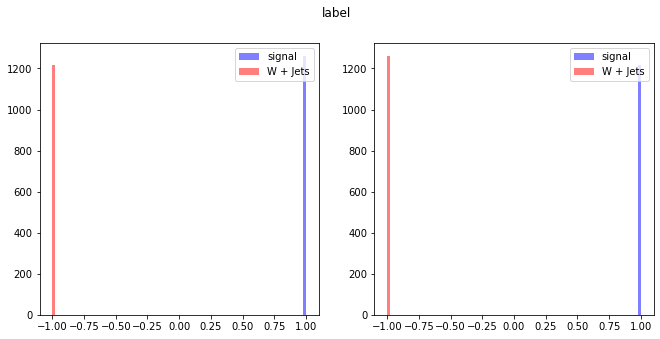

adabdt output
adabdt output


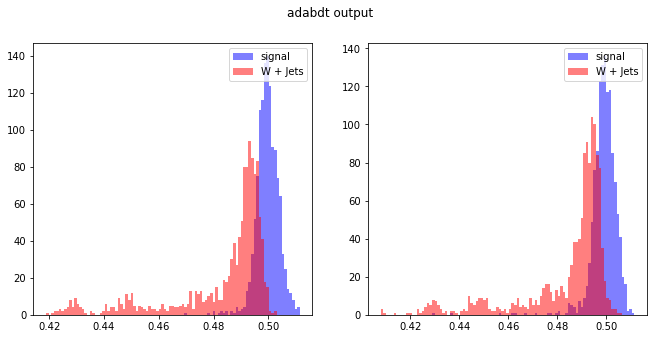

In [16]:
df_train = pd.DataFrame(X_train, columns=sig.columns)
df_train['label'] = y_train
#df['adabdt output'] = adabdt.decision_function(X_test)
#df['gradbdt output'] = gradbdt.decision_function(X_test)
df_train['adabdt output'] = adabdt.predict_proba(X_train)[:,1]
df_sig_train = df_train[df_train['label']==1.0]
df_bkg_train = df_train[df_train['label']==-1.0]

df_test = pd.DataFrame(X_test, columns=sig.columns)
df_test['label'] = y_test
#df['adabdt output'] = adabdt.decision_function(X_test)
#df['gradbdt output'] = gradbdt.decision_function(X_test)
df_test['adabdt output'] = adabdt.predict_proba(X_test)[:,1]
df_sig_test = df_test[df_test['label']==1.0]
df_bkg_test = df_test[df_test['label']==-1.0]


plot_variables_pairs(df_sig_train,df_bkg_train,df_sig_test,df_bkg_test)

In [17]:
cioa

NameError: name 'cioa' is not defined

In [ ]:
def plot_variables_pairs_same_binning(sig,bkg,sig_t,bkg_t):
    for i in sig.columns.to_list():
        
        fig = plt.figure()
        
        x_sig = sig[i].to_numpy()
        x_bkg = bkg[i].to_numpy()
        x_sig_t = sig_t[i].to_numpy()
        x_bkg_t = bkg_t[i].to_numpy()
        
        bins = np.linspace(min([min(x_sig),min(x_bkg),min(x_sig_t),min(x_bkg_t)]),max([max(x_sig),max(x_bkg),max(x_sig_t),max(x_bkg_t)]), 20)
        
        print(i)
        

            
        plt.hist(x_sig_t, bins, alpha=0.5, label='signal (test)', density=True, color='blue')
        plt.hist(x_bkg_t, bins, alpha=0.5, label='background (test)', density=True, color='red')
        
        y,binEdges = np.histogram(x_sig,bins=bins, density = True)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        #menStd     = np.sqrt(y)
        menStd     = np.zeros(y.shape[0])
        #plt.errorbar(bincenters, y,  color='b', yerr=menStd, label='signal (train)', fmt='o')
        plt.scatter(bincenters, y,  color='b', label='signal (train)')
        
        y,binEdges = np.histogram(x_bkg,bins=bins, density = True)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        #menStd     = np.sqrt(y)
        menStd     = np.zeros(y.shape[0])
        #plt.errorbar(bincenters, y,  color='r', yerr=menStd, label='background (train)', fmt='o')
        plt.scatter(bincenters, y,  color='r', label='background (train)',) 
        
        plt.legend()
        
        plt.grid()
        
        plt.show()

plot_variables_pairs_same_binning(df_sig_train,df_bkg_train,df_sig_test,df_bkg_test)

# Test methods

In [29]:
a = np.asarray([1,0,0,1,0])
a = np.reshape(a,(5,))
a.shape

(5,)

In [30]:
classes = np.asarray([0,1])
classes = np.reshape(classes, (2,))
classes.shape

(2,)

In [33]:
(a==classes).T * 2

<ipython-input-33-a7e836b145e0>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  (a==classes).T * 2


AttributeError: 'bool' object has no attribute 'T'

In [34]:
adabdt.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=209652396, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=398764591, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impuri

In [ ]:
pred = sum((estimator.predict(X) == classes).T * w
            for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))

In [35]:
adabdt.classes_

array([0., 1.])

In [56]:
X_test

classes = adabdt.classes_[:, np.newaxis]
pred = 0

print(X_test.shape)
for estimator, w in zip(adabdt.estimators_[:10],adabdt.estimator_weights_[:10]):
    print('predict:', estimator.predict(X_test[:3,:]))
    print('classes:', classes)
    print('(estimator.predict(X_test[:3,:]) == classes): ',(estimator.predict(X_test[:3,:]) == classes))
    print('(estimator.predict(X_test[:3,:]) == classes).T: ',(estimator.predict(X_test[:3,:]) == classes).T)
    print('w: ',w)
    print('(estimator.predict(X_test[:3,:]) == classes).T * w:', (estimator.predict(X_test[:3,:]) == classes).T * w)
    print()
    pred += (estimator.predict(X_test[:3,:]) == classes).T * w

print(pred)
print()

pred /= adabdt.estimator_weights_[:10].sum()

print(pred)
print()

pred[:, 0] *= -1

print(pred)
print()

pred = pred.sum(axis=1)
print(pred)
print()

(2479, 46)
predict: [1. 0. 0.]
classes: [[0.]
 [1.]]
(estimator.predict(X_test[:3,:]) == classes):  [[False  True  True]
 [ True False False]]
(estimator.predict(X_test[:3,:]) == classes).T:  [[False  True]
 [ True False]
 [ True False]]
w:  0.07413419294096134
(estimator.predict(X_test[:3,:]) == classes).T * w: [[0.         0.07413419]
 [0.07413419 0.        ]
 [0.07413419 0.        ]]

predict: [1. 0. 0.]
classes: [[0.]
 [1.]]
(estimator.predict(X_test[:3,:]) == classes):  [[False  True  True]
 [ True False False]]
(estimator.predict(X_test[:3,:]) == classes).T:  [[False  True]
 [ True False]
 [ True False]]
w:  0.06672077364686524
(estimator.predict(X_test[:3,:]) == classes).T * w: [[0.         0.06672077]
 [0.06672077 0.        ]
 [0.06672077 0.        ]]

predict: [1. 1. 0.]
classes: [[0.]
 [1.]]
(estimator.predict(X_test[:3,:]) == classes):  [[False False  True]
 [ True  True False]]
(estimator.predict(X_test[:3,:]) == classes).T:  [[False  True]
 [False  True]
 [ True False]]
w:

In [50]:
pred = sum((estimator.predict(X_test) == classes).T * w
               for estimator, w in zip(adabdt.estimators_,
                                       adabdt.estimator_weights_))

print(pred)

pred /= adabdt.estimator_weights_.sum()

print(pred)
pred[:, 0] *= -1
print(pred)
print(pred.sum(axis=1))

[[12.204615   10.99102135]
 [10.56206075 12.63357559]
 [11.58402151 11.61161483]
 ...
 [14.48560861  8.71002774]
 [15.05327002  8.14236632]
 [10.81572727 12.37990908]]
[[0.52615996 0.47384004]
 [0.45534688 0.54465312]
 [0.4994052  0.5005948 ]
 ...
 [0.62449714 0.37550286]
 [0.64896991 0.35103009]
 [0.46628284 0.53371716]]
[[-0.52615996  0.47384004]
 [-0.45534688  0.54465312]
 [-0.4994052   0.5005948 ]
 ...
 [-0.62449714  0.37550286]
 [-0.64896991  0.35103009]
 [-0.46628284  0.53371716]]
[-0.05231991  0.08930623  0.00118959 ... -0.24899428 -0.29793982
  0.06743431]
